In [8]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

## Loading Dataset

In [9]:
data_dir = 'data\\plates\\train'

In [10]:
img_height = 256
img_width = 256

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  )

Found 40 files belonging to 2 classes.
Using 32 files for training.
Found 40 files belonging to 2 classes.
Using 8 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['cleaned', 'dirty']


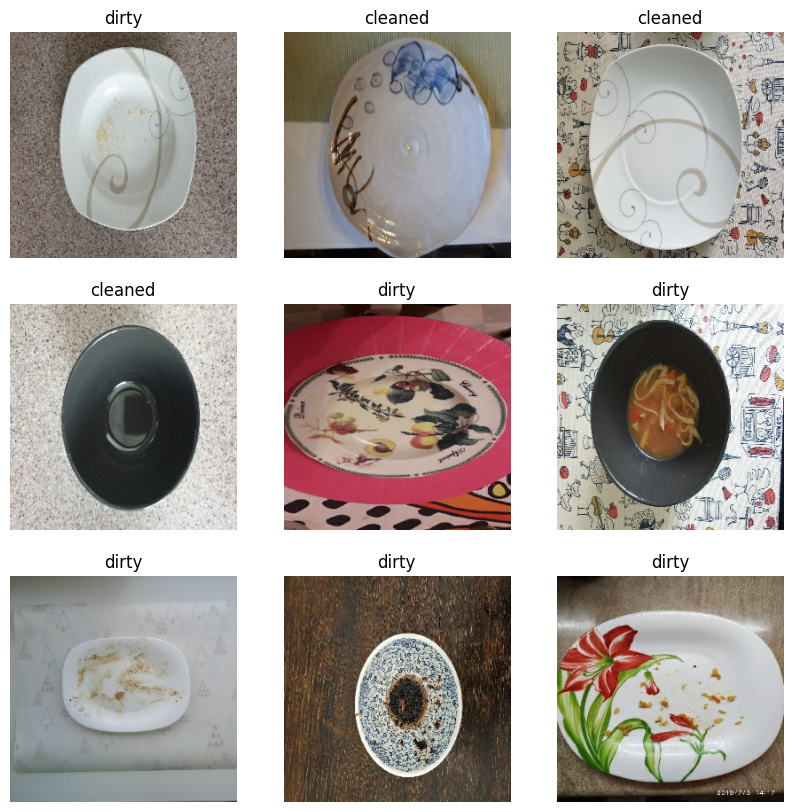

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),  # Horizontal flip
        layers.RandomRotation(0.9),  # Increase rotation range
        layers.RandomZoom(0.2),  # Increase zoom level for more scale variations
        layers.RandomContrast(0.4),  # Keep contrast adjustment
        layers.RandomCrop(256, 256),  # Crop to 256x256
        layers.RandomTranslation(0.2, 0.2)  # Translate 20% of the image
    ]
)


## Build Deep Learning Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, elu


In [18]:
model = Sequential()

# normalization layer
model.add(Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# Data augmentation layer
model.add(data_augmentation)

# model architecture
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

# Use GlobalAveragePooling2D instead of Flatten
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))  # Adding Dropout for regularization

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) # Sigmoid activation for binary classification

## Using Pretrained Models (Transfer Learning)

In [19]:
# Load a pretrained model (e.g., MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False, 
                                               weights='imagenet') 

# Freeze the base model's layers
base_model.trainable = False

# Create a new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Adding Dropout for regularization
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

## Model training

In [22]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [23]:
epochs=50

In [24]:
# Train the model
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.8203 - accuracy: 0.5312 - val_loss: 0.9242 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 104ms/step - loss: 0.8208 - accuracy: 0.5000 - val_loss: 0.7852 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 297ms/step - loss: 0.7147 - accuracy: 0.5938 - val_loss: 0.6978 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 101ms/step - loss: 0.7513 - accuracy: 0.5938 - val_loss: 0.6424 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 244ms/step - loss: 0.6119 - accuracy: 0.6250 - val_loss: 0.6147 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/50
1/1 [==============================] - 0s 103ms/step - loss: 0.7418 - accuracy: 0.5312 - val_loss: 0.6012 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/50
1/1 [==============================] - 0s 113ms/step - loss: 0.7809 - accu

## Plot Performance

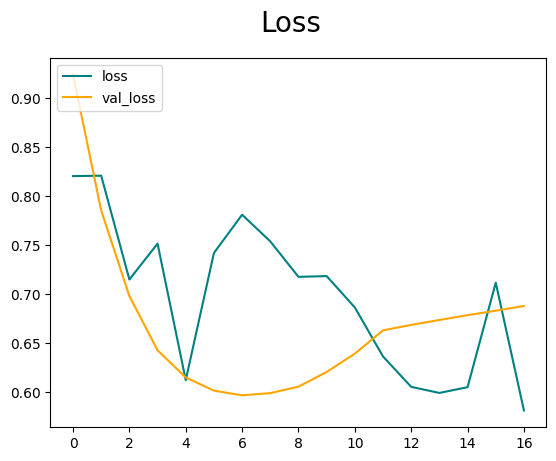

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

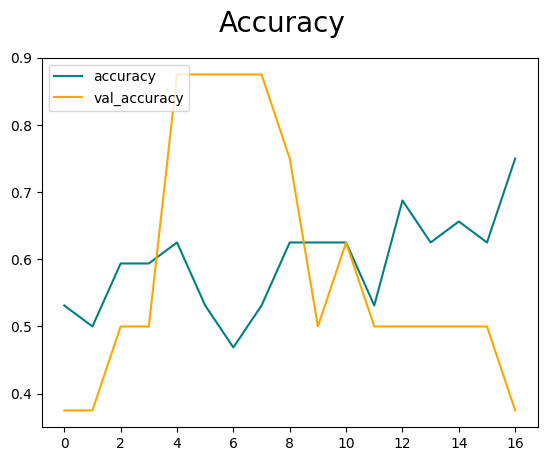

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Creating Submission

In [27]:
test_dir = 'data\\plates\\test'

In [28]:
# file names in the test directory
import os
test_files = os.listdir(test_dir)
print(test_files)

['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg', '0005.jpg', '0006.jpg', '0007.jpg', '0008.jpg', '0009.jpg', '0010.jpg', '0011.jpg', '0012.jpg', '0013.jpg', '0014.jpg', '0015.jpg', '0016.jpg', '0017.jpg', '0018.jpg', '0019.jpg', '0020.jpg', '0021.jpg', '0022.jpg', '0023.jpg', '0024.jpg', '0025.jpg', '0026.jpg', '0027.jpg', '0028.jpg', '0029.jpg', '0030.jpg', '0031.jpg', '0032.jpg', '0033.jpg', '0034.jpg', '0035.jpg', '0036.jpg', '0037.jpg', '0038.jpg', '0039.jpg', '0040.jpg', '0041.jpg', '0042.jpg', '0043.jpg', '0044.jpg', '0045.jpg', '0046.jpg', '0047.jpg', '0048.jpg', '0049.jpg', '0050.jpg', '0051.jpg', '0052.jpg', '0053.jpg', '0054.jpg', '0055.jpg', '0056.jpg', '0057.jpg', '0058.jpg', '0059.jpg', '0060.jpg', '0061.jpg', '0062.jpg', '0063.jpg', '0064.jpg', '0065.jpg', '0066.jpg', '0067.jpg', '0068.jpg', '0069.jpg', '0070.jpg', '0071.jpg', '0072.jpg', '0073.jpg', '0074.jpg', '0075.jpg', '0076.jpg', '0077.jpg', '0078.jpg', '0079.jpg', '0080.jpg', '0081.jpg', '0082.jpg', '00

In [29]:
# file formats in the test directory
test_formats = [f.split('.')[-1] for f in test_files]
print(np.unique(test_formats))

['jpg']


In [30]:
# Load the test data without expecting labels
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    labels='inferred',  # Set to 'inferred' since we don't have labels
    label_mode=None,  # No labels, so set mode to None
    color_mode='rgb',  # Assuming RGB images
    shuffle=False  # No need to shuffle test data
)

Found 744 files belonging to 1 classes.


In [31]:
# Predict the test data
predictions = model.predict(test_ds)
print(predictions)

24/24 [==============================] - 1s 43ms/step
[[0.74362296]
 [0.7650807 ]
 [0.22650062]
 [0.72280425]
 [0.79448026]
 [0.62317777]
 [0.6027704 ]
 [0.79156435]
 [0.674844  ]
 [0.66513574]
 [0.7002645 ]
 [0.7651011 ]
 [0.39326942]
 [0.60409445]
 [0.36484316]
 [0.63381857]
 [0.66851443]
 [0.7389331 ]
 [0.65964276]
 [0.5455665 ]
 [0.78294945]
 [0.77091795]
 [0.4914826 ]
 [0.6001271 ]
 [0.33042046]
 [0.48006228]
 [0.50793636]
 [0.45854586]
 [0.625564  ]
 [0.7469988 ]
 [0.46342793]
 [0.6916719 ]
 [0.7654084 ]
 [0.7916178 ]
 [0.8011293 ]
 [0.727541  ]
 [0.697454  ]
 [0.6033256 ]
 [0.81397724]
 [0.8770657 ]
 [0.59400654]
 [0.7821127 ]
 [0.661311  ]
 [0.7506212 ]
 [0.6472149 ]
 [0.7228249 ]
 [0.7599088 ]
 [0.7193531 ]
 [0.75514436]
 [0.76014435]
 [0.6062718 ]
 [0.8151505 ]
 [0.42716843]
 [0.57349575]
 [0.4529759 ]
 [0.51696515]
 [0.7579754 ]
 [0.66289043]
 [0.5257337 ]
 [0.4886441 ]
 [0.61601305]
 [0.67946124]
 [0.4740551 ]
 [0.78839207]
 [0.8304911 ]
 [0.78294665]
 [0.5178189 ]
 [0.3127

In [32]:
# Get the predicted class: 0 or 1
predicted_classes = (predictions > 0.5).astype("int32") # Convert boolean to 0 or 1
predicted_classes = predicted_classes.flatten() # Flatten to get a 1D array
print(predicted_classes)

[1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0
 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [33]:
# create a dataframe with filenames and predictions
df = pd.DataFrame({
    'id': [x.split('.')[0] for x in test_files],
    'label': ['dirty' if p == 1 else 'cleaned' for p in predicted_classes]
})
df.head()

,id,label
0,0000,dirty
1,0001,dirty
2,0002,cleaned
3,0003,dirty
4,0004,dirty


In [34]:
df.to_csv('predictions.csv', index=False)

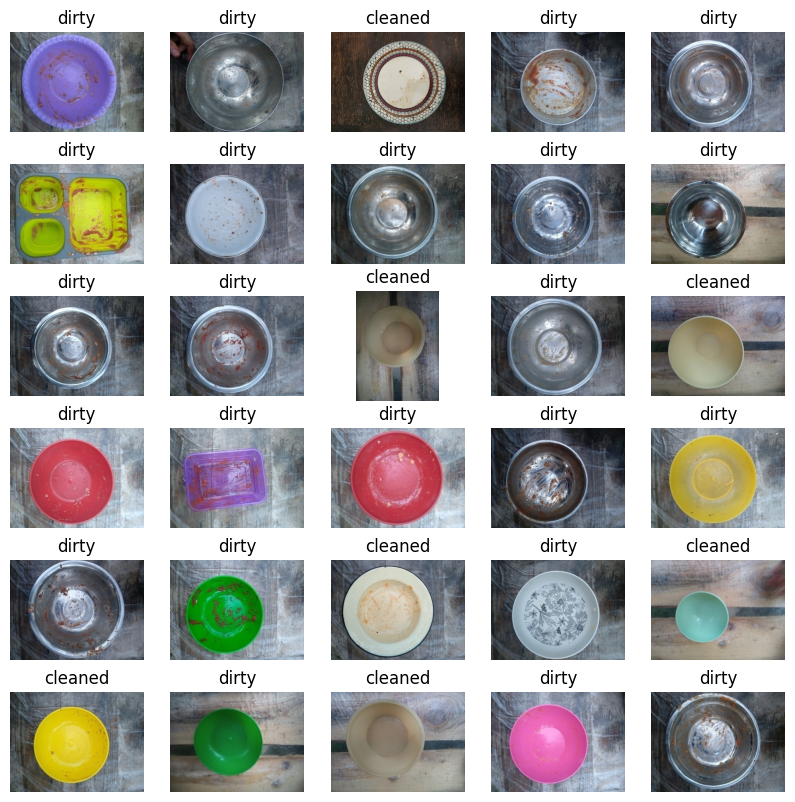

In [35]:
# plot 30 predictions images and their labels
plt.figure(figsize=(10, 10))
for i in range(30):
    ax = plt.subplot(6, 5, i + 1)
    plt.imshow(tf.keras.preprocessing.image.load_img(
        os.path.join(test_dir, test_files[i])
    ))
    plt.title(df['label'][i])
    plt.axis("off")
plt.show()
